### YOU CAN IGNORE THIS FILE AND INSTEAD USE THE .py

In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
from sklearn.linear_model import LinearRegression
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

In [388]:
def impute_missing_values(X):
    X_df = pd.DataFrame(X)
    #print("Before imputation NaN count per row:", X_df.isna().sum(axis=1))
    
    #X_df.ffill(axis=1, inplace=True)
    #print("After forward fill NaN count per row:", X_df.isna().sum(axis=1))

    #X_df.bfill(axis=1, inplace=True)
    #print("After backward fill NaN count per row:", X_df.isna().sum(axis=1))

    #X_df.interpolate(method='linear', limit_direction='both', axis=1, inplace=True)
    #print("After interpolation NaN count per row:", X_df.isna().sum(axis=1))

    medians = X_df.median(axis=1)
    for idx in X_df.index:
        X_df.loc[idx] = X_df.loc[idx].fillna(medians[idx])
    #print("After filling with median NaN count per row:", X_df.isna().sum(axis=1))
    
    return X_df.to_numpy()


In [389]:
def compute_linear_features(trend):
    mean_value = np.mean(trend)
    variance_value = np.var(trend)

    time_points = np.arange(len(trend)).reshape(-1, 1) 
    model = LinearRegression()
    model.fit(time_points, trend)
    slope_value = model.coef_[0]
    
    return {'slope': slope_value, 'mean': mean_value, 'variance': variance_value}

In [390]:
def compute_spline_features(trend, smoothing_factor):
    time_points = np.arange(len(trend))
    spline = UnivariateSpline(time_points, trend, s=smoothing_factor)

    # First and second derivatives
    first_derivative = spline.derivative()
    second_derivative = spline.derivative(n=2)

    # Slope metrics
    slope_mean = np.mean(first_derivative(time_points))
    slope_variance = np.var(first_derivative(time_points))

    # Curvature metrics
    curvature_mean = np.mean(second_derivative(time_points))
    curvature_max = np.max(np.abs(second_derivative(time_points)))

    # Inflection points (where second derivative changes sign)
    inflection_points = np.where(np.diff(np.sign(second_derivative(time_points))))[0]
    num_inflection_points = len(inflection_points)

    # Peaks and troughs
    critical_points = np.where(np.abs(first_derivative(time_points)) < 1e-6)[0]
    peaks = critical_points[second_derivative(critical_points) < 0]
    troughs = critical_points[second_derivative(critical_points) > 0]
    num_peaks = len(peaks)
    num_troughs = len(troughs)

    # Amplitude metrics (peak-to-trough distance)
    #amplitudes = spline(peaks) - spline(troughs) if len(peaks) > 0 and len(troughs) > 0 else []

    # Total variation (sum of absolute changes in the spline)
    total_variation = np.sum(np.abs(np.diff(spline(time_points))))

    # Area Under the Curve calculations
    # Dense sampling for more accurate integration
    dense_time = np.linspace(0, len(trend) - 1, 1000)
    dense_values = spline(dense_time)
    
    # Calculate different AUC metrics
    # 1. Raw integral (can be negative)
    raw_auc = spline.integral(0, len(trend) - 1)
    
    # 2. Absolute area (total area regardless of sign)
    absolute_auc = np.trapz(np.abs(dense_values), dense_time)

    return {
        'slope_mean': slope_mean,
        'slope_variance': slope_variance,
        'curvature_mean': curvature_mean,
        'curvature_max': curvature_max,
        'num_inflection_points': num_inflection_points,
        #'num_peaks': num_peaks,
        #'num_troughs': num_troughs,
        #'amplitude_mean': np.mean(amplitudes) if len(amplitudes) > 0 else 0,
        'total_variation': total_variation,
        #'raw_auc': raw_auc,
        'absolute_auc': absolute_auc
    }

In [391]:

def ssa_first_component_and_plot(X, window_size, smoothing_factor, threshold, plot = False):

    # Remove features with more than threshold% missing values
    #missing_percentages = X.isnull().mean()  
    #X = X.loc[:, missing_percentages <= threshold]

    features = [col for col in X.columns if 'norm' not in col and col not in ['pid', 'date', 'week_label', 'sequential_week']]
    unique_ids = X['pid'].unique()

    all_features = {pid: {} for pid in unique_ids}

    # Initially empty, to store feature keys after processing first valid sample
    feature_keys = []
    
    for var in features:  
        print(f"Processing feature: {var}")
        
        # Pivot the long format data to wide format
        wide_data = X.pivot(index='pid', columns='date', values=var)
        print("Initial shape:", wide_data.shape)

        # calculate the percentage of missing data for each sample
        missing_percentages = wide_data.isnull().mean(axis=1)
        filtered_data = wide_data.loc[missing_percentages <= threshold]
        print("Filtered shape:", filtered_data.shape)

        # Keep track of excluded smaples
        excluded_pids = wide_data.index.difference(filtered_data.index)

        # Impute missing values and convert to numpy array
        filtered_data_np = impute_missing_values(filtered_data)
        #wide_data_np = impute_missing_values(wide_data)

        # Confirm no NaN values before passing to SSA
        if np.isnan(filtered_data_np).any():
            raise ValueError("NaN values detected in input data to SSA.")
        
        # We decompose the time series into the first major component only
        groups = [[0], [1, 2, 3, 4, 5, 6]]
        ssa = SingularSpectrumAnalysis(window_size=window_size, groups = groups)
        
        # Fit the model and extract the first component
        X_ssa = ssa.fit_transform(filtered_data_np)
        first_component = X_ssa[:, 0, :]
    
        # Compute linear regression-based features for the first reconstructed component of each sample
        for pid, trend in zip(filtered_data.index, first_component):
            features_spline = compute_spline_features(trend, smoothing_factor)
            features_line = compute_linear_features(trend)
            combined_features = {f"{var}_{key}": value for key, value in {**features_spline, **features_line}.items()}
            all_features[pid].update(combined_features)

            # Collect feature keys from the first processed sample
            if not feature_keys:
                feature_keys = list(combined_features.keys())
    
        if plot:
            # Plotting the original and the reconstructed first component for one sample
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_data_np[0], 'o-', label='Original Time Series', alpha = 0.6)
            plt.plot(X_ssa[0, 0], 'o--', label='First Reconstructed Component', alpha = 0.7)
            
            # Spline fit
            time_points = np.arange(len(X_ssa[0, 0]))
            spline = UnivariateSpline(time_points, X_ssa[0, 0], s=smoothing_factor)
            plt.plot(time_points, spline(time_points), '-', label=f'Spline Fit (s={smoothing_factor})', linewidth=2, alpha=0.9)

            # Linear fit
            linear_model = LinearRegression()
            linear_model.fit(time_points.reshape(-1, 1), X_ssa[0, 0])
            plt.plot(time_points, linear_model.predict(time_points.reshape(-1, 1)), 'r--', label='Linear Fit', linewidth=1)
            
            plt.title('Comparison of Original and Reconstructed Time Series')
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.show()

    # Fill features for excluded samples with NaN
    nan_features = {key: np.nan for key in feature_keys}
    for pid in excluded_pids:
        all_features[pid].update(nan_features)
    
    # Convert the dictionary to a DataFrame
    feature_df = pd.DataFrame.from_dict(all_features, orient='index')
        
    return feature_df
    

In [422]:
call_2018 = pd.read_csv("Cleaned_Datasets/2021/screen_2021_data.csv", low_memory=False)
call_2018.shape


(13845, 5)

In [423]:
window_size = 7
smoothing_factor = 5

Processing feature: f_screen:phone_screen_rapids_sumdurationunlock:allday
Initial shape: (195, 71)
Filtered shape: (194, 71)


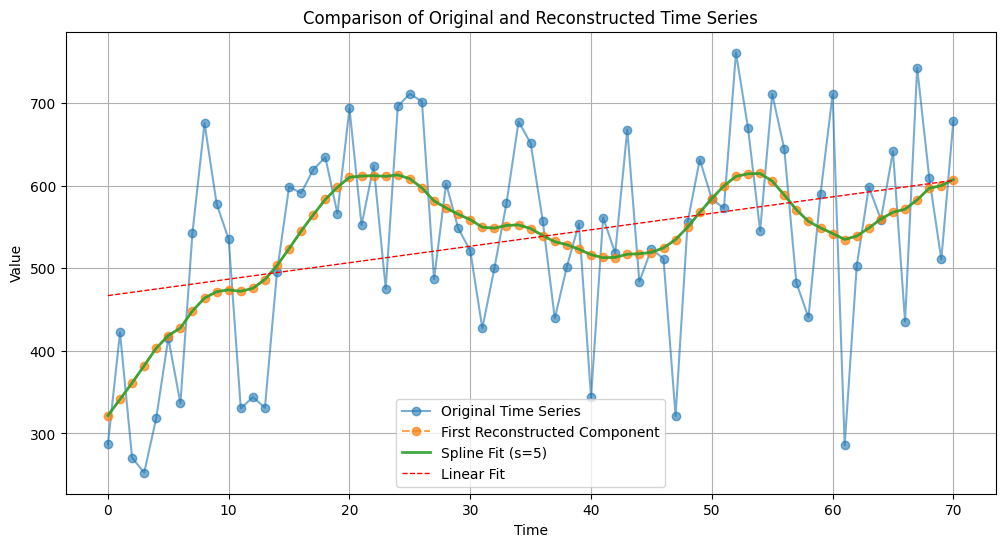

Processing feature: f_screen:phone_screen_rapids_countepisodeunlock:allday
Initial shape: (195, 71)
Filtered shape: (194, 71)


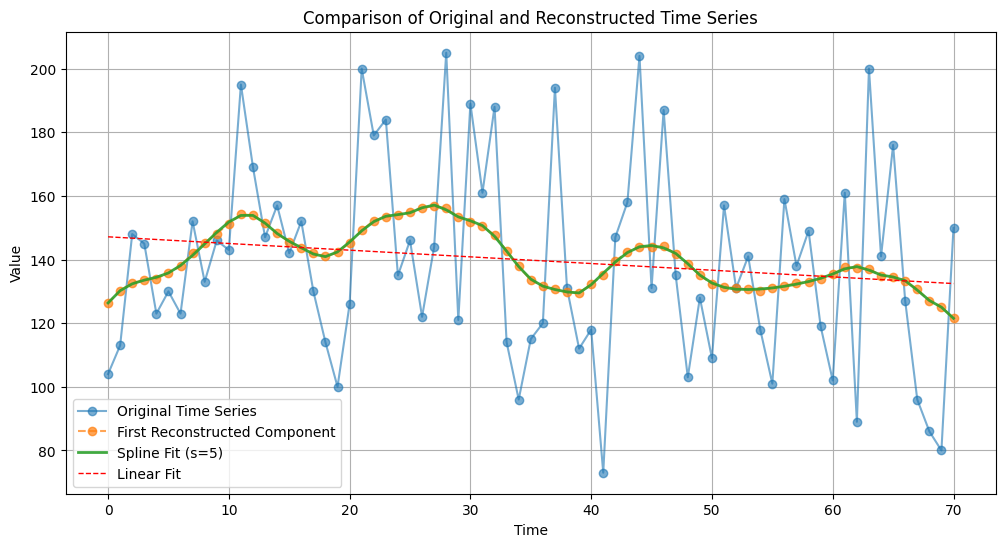

Processing feature: f_screen:phone_screen_rapids_firstuseafter00unlock:allday
Initial shape: (195, 71)
Filtered shape: (194, 71)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: 

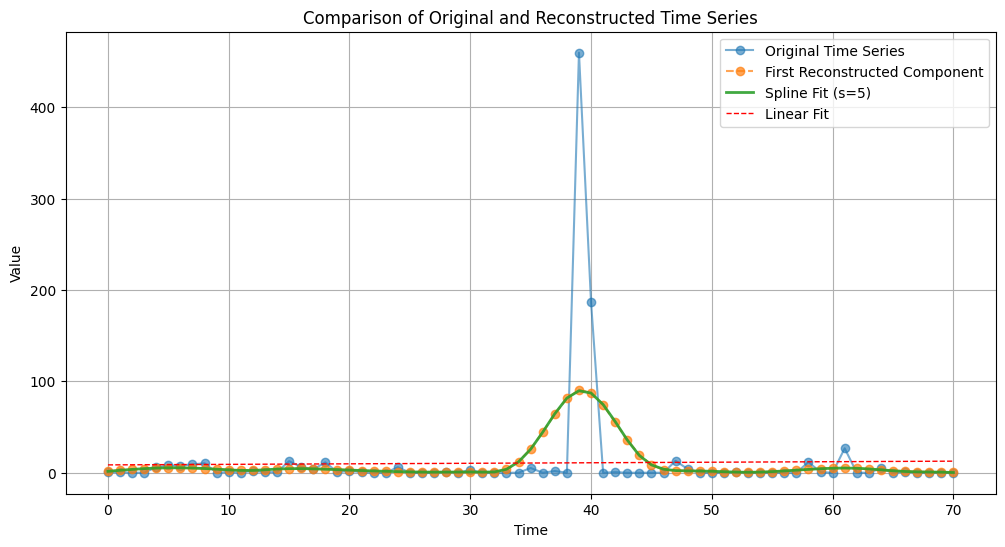

In [424]:
feature_df = ssa_first_component_and_plot(call_2018, window_size, smoothing_factor, threshold = 0.8, plot=True)


In [384]:
feature_df.shape

(195, 80)

In [385]:
feature_df.describe()

,f_call:phone_calls_rapids_missed_count:allday_slope_mean,f_call:phone_calls_rapids_missed_count:allday_slope_variance,f_call:phone_calls_rapids_missed_count:allday_curvature_mean,f_call:phone_calls_rapids_missed_count:allday_curvature_max,f_call:phone_calls_rapids_missed_count:allday_num_inflection_points,f_call:phone_calls_rapids_missed_count:allday_total_variation,f_call:phone_calls_rapids_missed_count:allday_absolute_auc,f_call:phone_calls_rapids_missed_count:allday_slope,f_call:phone_calls_rapids_missed_count:allday_mean,f_call:phone_calls_rapids_missed_count:allday_variance,...,f_call:phone_calls_rapids_outgoing_distinctcontacts:allday_slope_mean,f_call:phone_calls_rapids_outgoing_distinctcontacts:allday_slope_variance,f_call:phone_calls_rapids_outgoing_distinctcontacts:allday_curvature_mean,f_call:phone_calls_rapids_outgoing_distinctcontacts:allday_curvature_max,f_call:phone_calls_rapids_outgoing_distinctcontacts:allday_num_inflection_points,f_call:phone_calls_rapids_outgoing_distinctcontacts:allday_total_variation,f_call:phone_calls_rapids_outgoing_distinctcontacts:allday_absolute_auc,f_call:phone_calls_rapids_outgoing_distinctcontacts:allday_slope,f_call:phone_calls_rapids_outgoing_distinctcontacts:allday_mean,f_call:phone_calls_rapids_outgoing_distinctcontacts:allday_variance
count,181.000000,1.810000e+02,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,...,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,0.001145,6.373590e-03,-0.000367,0.022792,1.491713,2.044544,61.757210,0.000464,0.880709,0.280394,...,-0.000335,0.055312,-0.000462,0.107203,2.679558,5.560966,156.189796,-0.001661,2.229737,1.805341
std,0.017080,3.080844e-02,0.003478,0.074505,1.447675,3.934093,93.536340,0.016739,1.335456,1.264033,...,0.035509,0.407315,0.018612,0.405953,2.332636,10.111628,196.438517,0.046993,2.798105,10.814716
min,-0.134811,1.251516e-07,-0.031463,0.000034,0.000000,0.020299,0.205049,-0.167666,0.002012,0.000283,...,-0.227361,0.000000,-0.224413,0.000000,0.000000,0.000000,0.000000,-0.434930,0.000000,0.000000
25%,-0.004720,6.670185e-05,-0.000446,0.001260,1.000000,0.525295,16.315607,-0.002978,0.232448,0.024210,...,-0.007977,0.000299,-0.000585,0.002837,1.000000,0.981055,67.816884,-0.005414,0.967968,0.060590
50%,0.001372,2.766913e-04,-0.000050,0.002398,1.000000,0.994193,46.134369,0.000364,0.663966,0.061544,...,0.001419,0.001801,0.000228,0.011059,2.000000,2.401975,97.968567,0.000153,1.403424,0.213807
75%,0.006348,9.586592e-04,0.000438,0.006108,1.000000,1.661796,70.982674,0.003858,1.014295,0.128790,...,0.012005,0.017708,0.001646,0.092014,4.000000,6.613380,178.553290,0.009253,2.551168,0.646010
max,0.088456,3.050780e-01,0.015678,0.605179,8.000000,30.866367,777.915735,0.066772,11.092008,15.371152,...,0.110707,5.405001,0.074093,5.097790,16.000000,110.827095,1782.389271,0.100564,25.340475,129.847864


In [386]:
feature_df.isna().mean().mean()

0.1032051282051282